**Run the demo.** Run the following cells to compute semantic correspondences for real image pairs.

In [4]:
%load_ext autoreload
%autoreload 2
from archs.stable_diffusion.diffusion import latent_to_image
from archs.stable_diffusion.resnet import collect_dims
from archs.correspondence_utils import (
  process_image,
  rescale_points,
  draw_correspondences,
  compute_pck,
  find_nn_source_correspondences,
  find_best_buddies_correspondences,
  find_cyclical_correspondences,
)
import os
import random
import torch

import einops
import math
from omegaconf import OmegaConf
import matplotlib.pyplot as plt

from PIL import Image
import numpy as np
import json
import torchvision

from extract_hyperfeatures import load_models

In [5]:
# Memory requirement is 13731MiB
device = "cuda"
config_path = "configs/real.yaml"
config, diffusion_extractor, aggregation_network = load_models(config_path, device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

diffusion_mode: inversion
idxs: [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2)]
output_resolution: 64
prompt: 
negative_prompt: 


c:\Users\saqib\miniconda3\envs\pytorch_env\lib\site-packages\transformers\models\clip\modeling_clip.py:491: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [13]:
def load_image(ann, load_size, device, image_path=""):
    img_pil = Image.open(f"{image_path}/{ann['source_path']}").convert("RGB")
    size = img_pil.size
    if "source_points" in ann:
        points = ann["source_points"]
        points = np.flip(points, 1)
        points = rescale_points(points, size, load_size)
    else:
        points = None 
    
    img, img_pil = process_image(image_pil=img_pil, res=size)
    img = img.to(device)
    return points, img_pil, img


In [7]:
def load_image_pair(ann, load_size, device, image_path=""):
  img1_pil = Image.open(f"{image_path}/{ann['source_path']}").convert("RGB")
  img2_pil = Image.open(f"{image_path}/{ann['target_path']}").convert("RGB")
  source_size = img1_pil.size
  target_size = img2_pil.size

  # swap from (x, y) to (y, x)
  if "source_points" in ann:
    source_points, target_points = ann["source_points"], ann["target_points"]
    source_points = np.flip(source_points, 1)
    target_points = np.flip(target_points, 1)
    source_points = rescale_points(source_points, source_size, load_size)
    target_points = rescale_points(target_points, target_size, load_size)
  else:
    source_points, target_points = None, None

  img1, img1_pil = process_image(img1_pil, res=load_size)
  img2, img2_pil = process_image(img2_pil, res=load_size)
  img1, img2 = img1.to(device), img2.to(device)
  imgs = torch.cat([img1, img2])
  
  return source_points, target_points, img1_pil, img2_pil, imgs

def load_saliency_pair(ann, output_size, device, saliency_path=""):
  def _load_saliency(path):
    if os.path.exists(path):
      saliency_pil = Image.open(path).convert("L")
      saliency_map, _ = process_image(saliency_pil, res=output_size, range=(0, 1))
      saliency_map = einops.rearrange(saliency_map, 'b c h w -> (b c) (h w)')
    else:
      saliency_map = torch.ones((1, output_size[0] * output_size[1]))
    saliency_map = saliency_map.to(device)
    return saliency_map
  saliency_map1 = _load_saliency(f"{saliency_path}/{ann['source_path']}")
  print("saliency map", saliency_map1)
  saliency_map2 = _load_saliency(f"{saliency_path}/{ann['target_path']}")
  return saliency_map1, saliency_map2

def reshape_descriptors(img1_feats, img2_feats):
  b, d, w, h = img1_feats.shape
  descriptors1 = img1_feats.view((b, d, -1)).permute((0, 2, 1))[:, None, ...]
  descriptors2 = img2_feats.view((b, d, -1)).permute((0, 2, 1))[:, None, ...]
  return descriptors1, descriptors2

def postprocess_points(source_points, predicted_points, output_size, load_size):
  source_points = source_points.detach().cpu().numpy()
  predicted_points = predicted_points.detach().cpu().numpy()
  source_points = rescale_points(source_points, output_size, load_size)
  predicted_points = rescale_points(predicted_points, output_size, load_size)
  return source_points, predicted_points

**Compute semantic keypoint matches.** Use one of the correspondence functions:
- `nearest_neighbors`: For a set of annotated source_points, compute the nearest neighbor predicted_points.
- `best_buddies`: Compute the top-k pairs of source_points, predicted_points using the [best buddies algorithm](https://github.com/ShirAmir/dino-vit-features) (Amir et. al., ECCVW 2022).

In [8]:
import matplotlib.pyplot as plt
import cv2

In [9]:
img_path = "assets/spair/images/2007_005797.jpg"
img = cv2.imread(img_path)
slncy_path = "assets/spair/odise/2007_005797.jpg"
mask = cv2.imread(slncy_path)

(-0.5, 499.5, 374.5, -0.5)

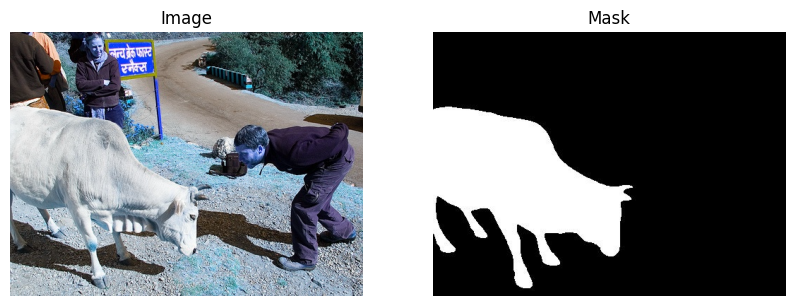

In [10]:
# Create a figure with 1 row and 2 columns
plt.figure(figsize=(10, 5))

# Plot the first image in the first subplot (row 1, column 1)
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Image")
plt.axis('off')  # Turn off the axis

# Plot the second image in the second subplot (row 1, column 2)
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Mask")
plt.axis('off')  # Turn off the axis

In [11]:
image_path = "assets/spair/images"
saliency_path = "assets/spair/odise"
annotation_path = "annotations/spair_71k_test-6.json"
load_size = (224, 224)
output_size = (config["output_resolution"], config["output_resolution"])

# Select from [nearest_neighbors, best_buddies]
correspondence_function = "nearest_neighbors"
# Number of correspondences to display when using [best_buddies]
num_pairs = 10

torch.Size([384, 64, 64])


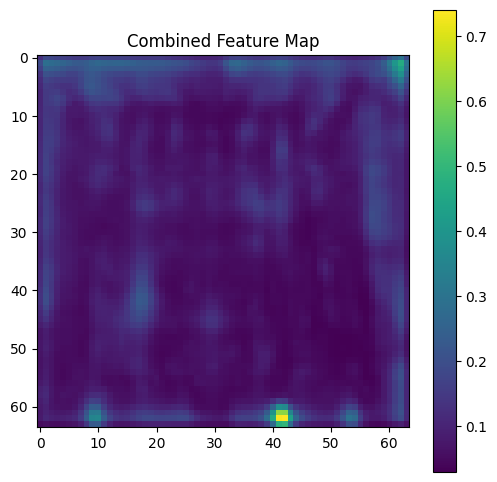

torch.Size([384, 64, 64])


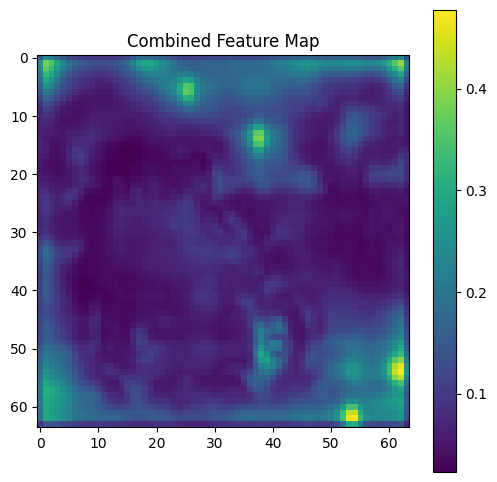

torch.Size([384, 64, 64])


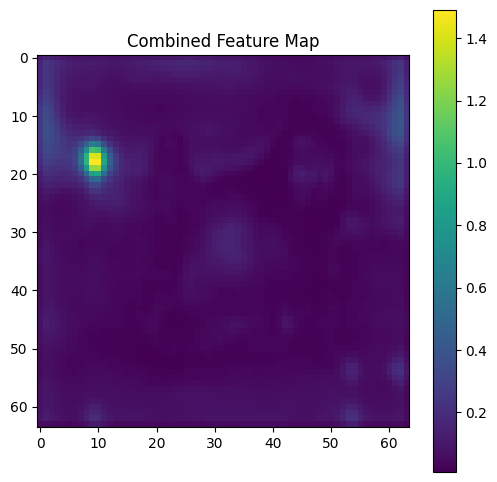

torch.Size([384, 64, 64])


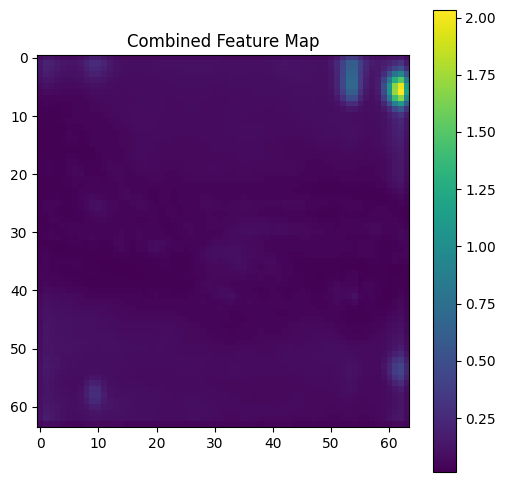

torch.Size([384, 64, 64])


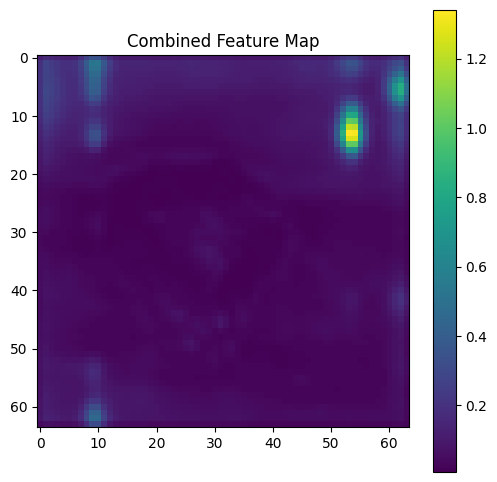

torch.Size([384, 64, 64])


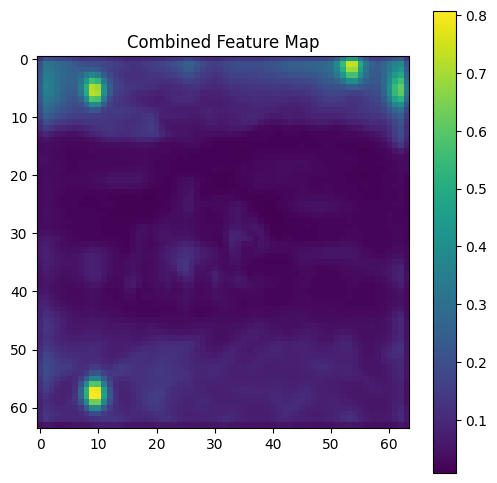

In [14]:
for ann in json.load(open(annotation_path)):
    source_points, target_points, img1_pil, img2_pil, imgs = load_image_pair(ann, load_size, device, image_path)
    with torch.inference_mode():
        with torch.autocast("cuda"):
            feats, _ = diffusion_extractor.forward(imgs)
            b, s, l, w, h = feats.shape
            diffusion_hyperfeats = aggregation_network(feats.float().view((b, -1, w, h)))
            img1_hyperfeats = diffusion_hyperfeats[0][None, ...]
            img1_hyperfeats = img1_hyperfeats[0]
            print(img1_hyperfeats.shape)
            # num_channels = img1_hyperfeats.shape[0]
            # fig, axes = plt.subplots(3, 4, figsize=(12, 12))
            # axes = axes.flatten()
            # for i in range(min(num_channels, 12)):  # Plot up to 12 channels
            #     ax = axes[i]
            #     feature_map = img1_hyperfeats[i].cpu().numpy() 
            #     assert feature_map.shape == (64, 64),f"Shape of feature_map is incorrect: {feature_map.shape}"
            #     ax.imshow(feature_map, cmap='viridis',vmin=feature_map.min(), vmax=feature_map.max())  # Mean across the spatial grid
            #     ax.set_title(f"Channel {i+1}")
            #     ax.axis('off')  # Turn off axis for cleaner visualization
            # plt.tight_layout()
            # plt.show()
            # combined_feature_map = img1_hyperfeats.mean(dim=0)

            # plt.figure(figsize=(6, 6))
            # plt.imshow(combined_feature_map.cpu().numpy(), cmap='viridis', vmin=combined_feature_map.min(), vmax=combined_feature_map.max())
            # plt.title("Combined Feature Map")
            # plt.colorbar()
            # plt.show()

            img2_hyperfeats = diffusion_hyperfeats[1][None, ...]
            img2_hyperfeats = img2_hyperfeats[0]
            num_channels = img2_hyperfeats.shape[0]
            combined_feature_map_1 = img2_hyperfeats.mean(dim=0)
            plt.figure(figsize=(6, 6))
            plt.imshow(combined_feature_map_1.cpu().numpy(), cmap='viridis', vmin=combined_feature_map_1.min(), vmax=combined_feature_map_1.max())
            plt.title("Combined Feature Map")
            plt.colorbar()
            plt.show()

   

      


In [ ]:
for ann in json.load(open(annotation_path)):
  source_points, target_points, img1_pil, img2_pil, imgs = load_image_pair(ann, load_size, device, image_path)
  
  with torch.inference_mode():
    with torch.autocast("cuda"):
      feats, _ = diffusion_extractor.forward(imgs)
      b, s, l, w, h = feats.shape
      diffusion_hyperfeats = aggregation_network(feats.float().view((b, -1, w, h)))
      img1_hyperfeats = diffusion_hyperfeats[0][None, ...]
      img2_hyperfeats = diffusion_hyperfeats[1][None, ...]

  if correspondence_function == "nearest_neighbors":
    _, predicted_points = find_nn_source_correspondences(img1_hyperfeats, img2_hyperfeats, source_points, output_size, load_size)
    predicted_points = predicted_points.detach().cpu().numpy()
    distances, _, pck_metric = compute_pck(predicted_points, target_points, load_size)
    title = f"Diffusion Hyperfeatures, Nearest Neighbors Matches \n PCK@0.1: {pck_metric.round(decimals=2)}"
  elif correspondence_function == "best_buddies":
    descriptors1, descriptors2 = reshape_descriptors(img1_hyperfeats, img2_hyperfeats)
    saliency_map1, saliency_map2 = load_saliency_pair(ann, output_size, img1_hyperfeats.device, saliency_path)
    print(saliency_map1)
    source_points, predicted_points = find_best_buddies_correspondences(descriptors1, descriptors2, saliency_map1, saliency_map2, num_pairs=num_pairs)
    source_points, predicted_points = postprocess_points(source_points, predicted_points, output_size, load_size)
    title = "Diffusion Hyperfeatures, Best Buddies Matches"
  else:
    raise NotImplementedError
  
  draw_correspondences(source_points, predicted_points, img1_pil, img2_pil, title=title)
  plt.show()